In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Capstone Project 1: Data Storytelling

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)
key = pd.read_csv('actual.csv', index_col=0)

sns.set()                       # sets default plot style
plt.rc('font', size=14)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # fontsize of the legend labels

drop_list = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=drop_list)

#Drop the 'Gene Description' row as it is not useful here
cleaned_data = data.drop(['Gene Description'], axis=1)
cleaned_data.columns = cleaned_data.columns.map(int)
cleaned_data.sort_index(axis=1, inplace=True)

#Transpose rows and columns so that each column is a different gene
transposed_data = cleaned_data.transpose()

#Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, transposed_data], axis=1, join='inner')

#Group by cancer type to aggregate and calculate mean and std for both cancer types
df_agg_trans = exp_data.groupby('cancer').agg(['mean', 'std'])

I first wanted to get an idea of what the gene expression data looked like for the ALL and AML cancers. As there are 7129 genes in the dataset, the best way to get a 'big picture' view of the data is to plot the empirical cumulative distribution function (ECDF) for the mean gene expression data for each of the cancer types. As expected, the two ECDFs look very similar; both cancer types display a range of gene expression levels, with some genes having very low expression and some genes having very high expression. The majority of the genes, approximately 40%, have expression levels between 100 to 1000, while a little under 15% of the genes are very highly expressed.

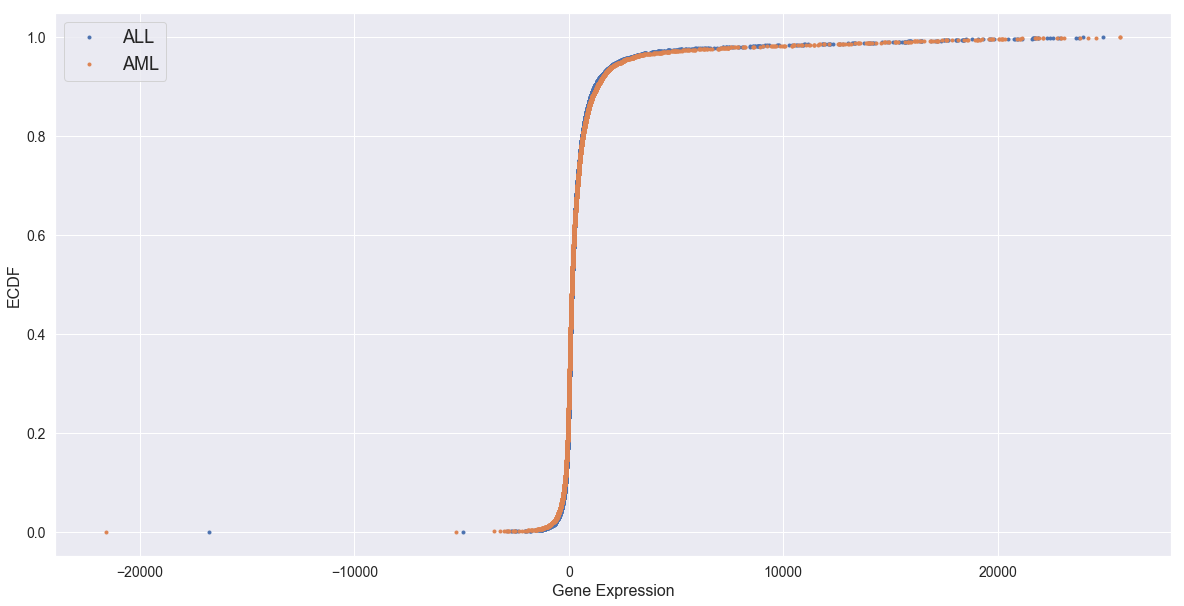

In [3]:
#Transpose dataframe so that genes form the rows
df_agg = df_agg_trans.transpose()

#Plot the empirical cumulative distribution function (ECDF) for ALL and AML mean gene expression
#First, slice out and sort ALL mean data and AML mean data to use as x-values of EDCF plots
ALL_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'ALL'])
AML_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'AML'])
#Calculate y-values for ECDF plots (evenly-spaced y-values with a maximum of 1)
y = (np.arange(1, len(ALL_mean)+1)) / len(ALL_mean)

plt.figure(figsize=(20, 10))
#Generate the ALL and AML ECDF plots
plt.plot(ALL_mean, y, marker='.', linestyle='none', label='ALL')
plt.plot(AML_mean, y, marker='.', linestyle='none', label='AML')
#Adjust x-scale, label axes, add a legend, and display the plots
#plt.xscale('log')           #plotting on logscale distorts y-values somehow
plt.xlabel('Gene Expression')
plt.ylabel('ECDF')
plt.legend()
plt.show()

I also plotted the mean gene expression for the ALL samples against the mean gene expression for the AML samples to quickly assess how many genes were expressed more in one cancer type that the other. In the plot below, a fairly large number of genes are expressed more highly in either the ALL samples or the AML samples. However, this type of plot does not accout for the 'signal-to-noise' ratio. 

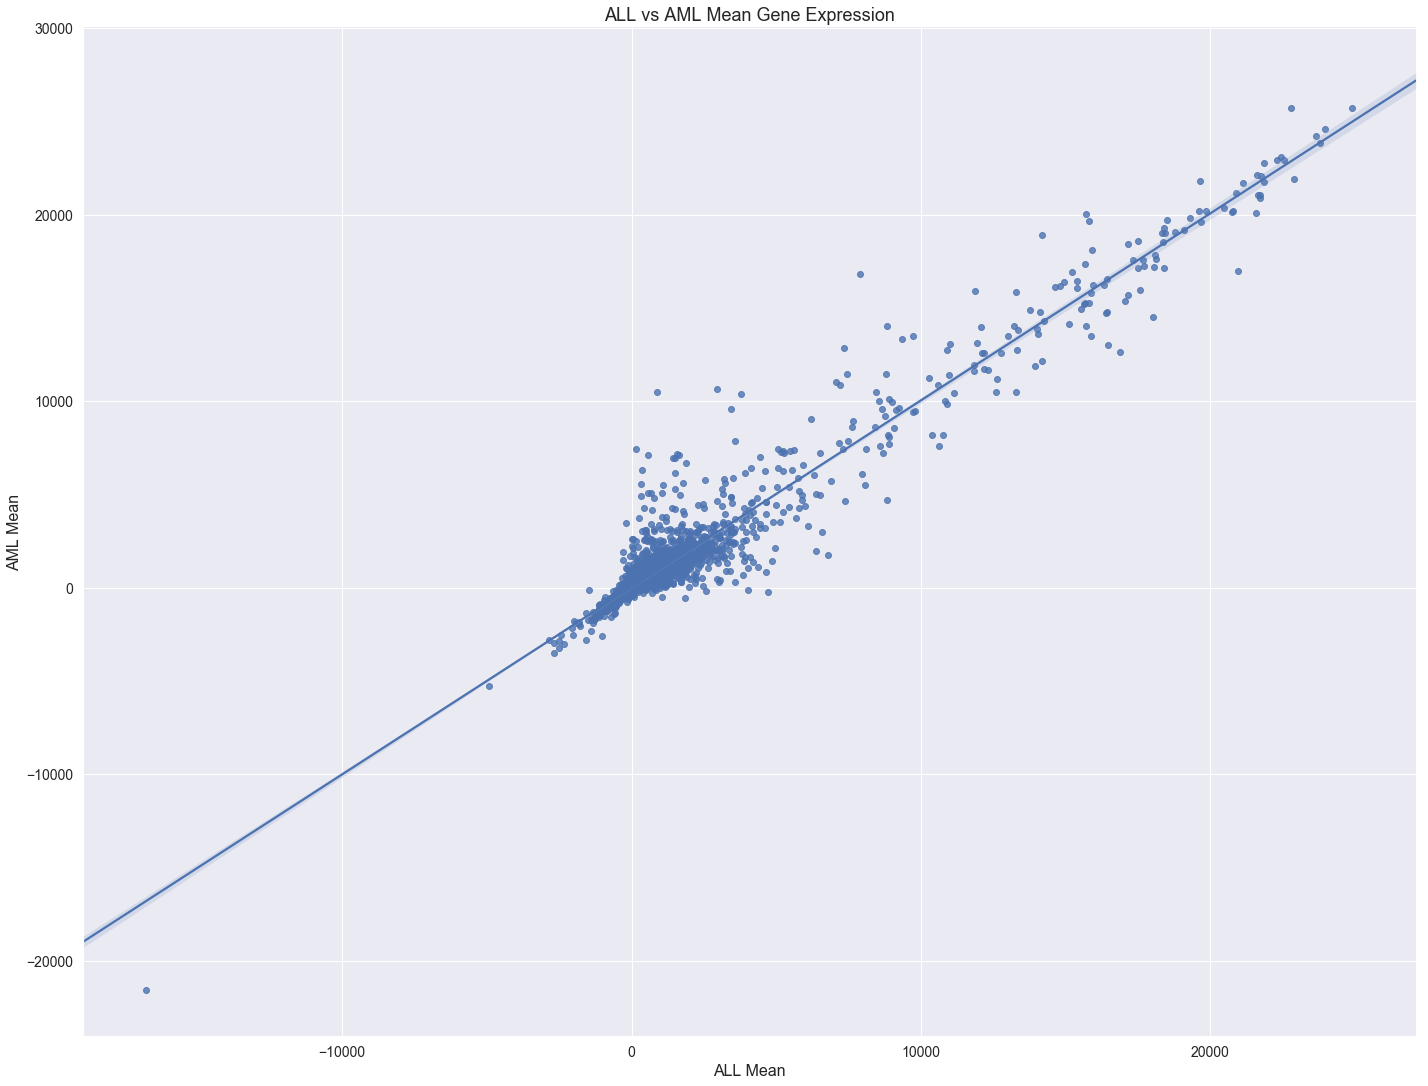

In [4]:
#Create dataframe containing just the ALL and AML mean data
means = df_agg.loc[(slice(None), 'mean'), 'ALL':'AML'].copy()
means.reset_index(level=1, inplace=True)
means.drop(columns='level_1', inplace=True)
means.columns = ['ALL_mean', 'AML_mean']

sns.lmplot(x='ALL_mean', y='AML_mean', data=means, height=15, aspect=1.33)
plt.xlabel('ALL Mean')
plt.ylabel('AML Mean')
plt.title('ALL vs AML Mean Gene Expression')
plt.show()

To get a better estimate of the genes that were most highly correlated with the ALL and AML cancer types, I need to account for the effect of the overall mean expression level and its standard deviation for each type of cancer. To estimate the correlation of each gene, I calculated the difference between the means and divided it by the sum of the standard deviation of the means:

$$ (\mu_{ALL} - \mu_{AML}) / (\sigma_{ALL} + \sigma_{AML}) $$

I then plotted a histogram of the correlation values to see the distribution. As you can see from the graph below, most genes have a low correlation value, and the histogram is centered around zero. The positive correlation values represent genes that are more highly expressed in the ALL samples, while the negative correlation values represent genes that are more highly expressed in the AML samples.

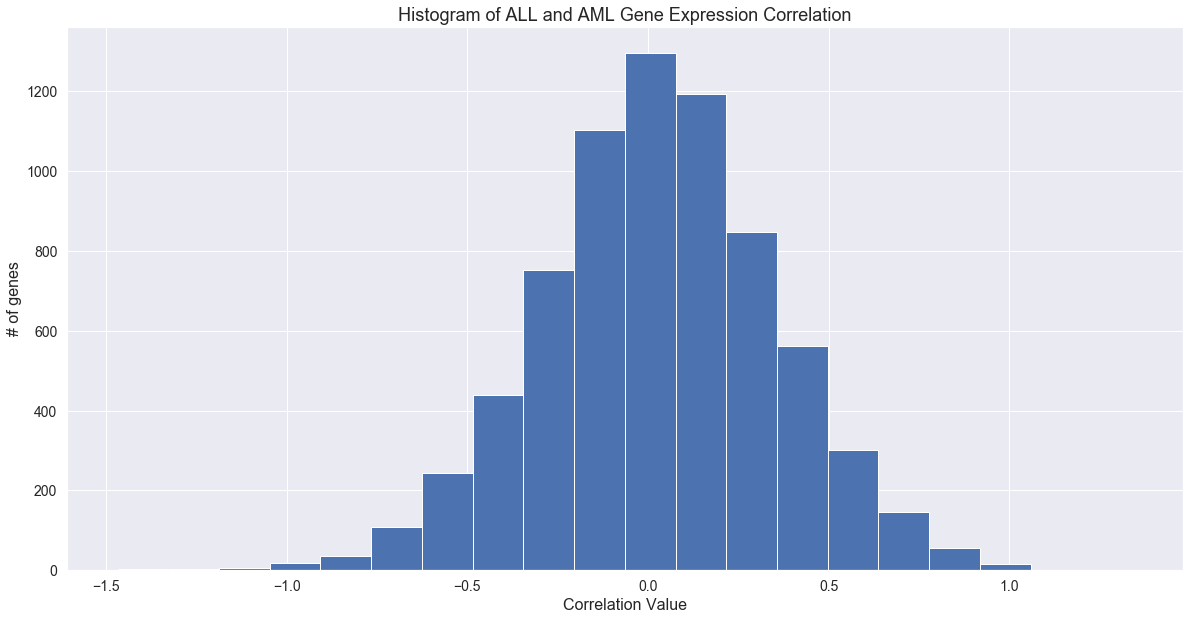

In [5]:
#Calculate the difference of ALL mean to AML mean for all genes and save in a new column, ALL:AML
df_agg.loc[(slice(None), 'mean'), 'ALL:AML'] = (df_agg['ALL'] - df_agg['AML'])
#Calculate the sum of ALL std to AML std for all genes and save column ALL:AML
df_agg.loc[(slice(None), 'std'), 'ALL:AML'] = (df_agg['ALL'] + df_agg['AML'])

mean_diff = df_agg.loc[(slice(None), 'mean'), 'ALL:AML'].copy()
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = df_agg.loc[(slice(None), 'std'), 'ALL:AML'].copy()
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)

#Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, figsize=(20,10))
plt.title('Histogram of ALL and AML Gene Expression Correlation')
plt.xlabel('Correlation Value')
plt.ylabel('# of genes')
plt.show()

In [12]:
#I want to take the means dataframe from before and add standard deviation information along with the other
#calculations for each gene

#Slice out the standard deviation data and rename the columns
stdev = df_agg.loc[(slice(None), 'std'), 'ALL':'AML'].copy()
stdev.reset_index(level=1, inplace=True)
stdev.drop(columns='level_1', inplace=True)
stdev.columns = ['ALL_stdev', 'AML_stdev']

#Finally, I will concat the means, stdev, and df_corr dataframes together into one dataframe
gene_summary = pd.concat([means, stdev, df_corr], axis=1)

#Filter dataset to include only the most highly correlated genes
top_genes = gene_summary[abs(gene_summary.correlation) > 0.8].copy()
top_genes.sort_values(by=['correlation'], inplace=True)
#Select the top 25 genes correlated with ALL cancer
top_genes_ALL = top_genes.iloc[-25:, :]
#Select the genes correlated with AML cancer
top_genes_AML = top_genes.iloc[0:25, :]

As my next step, I sorted the genes by their correlation values and selected the top 25 genes correlated with ALL expression (the 25 largest positive correlation values) and the top 25 genes correlated with AML expression (the 25 largest negative correlation values). I was then able to select the top 25 ALL genes and the top 25 AML genes and plot their mean expression levels and standard deviations in the bar charts below. As you can see, the standard deviations are all fairly large, indicating a wide variability in the gene expression levels between individual samples.

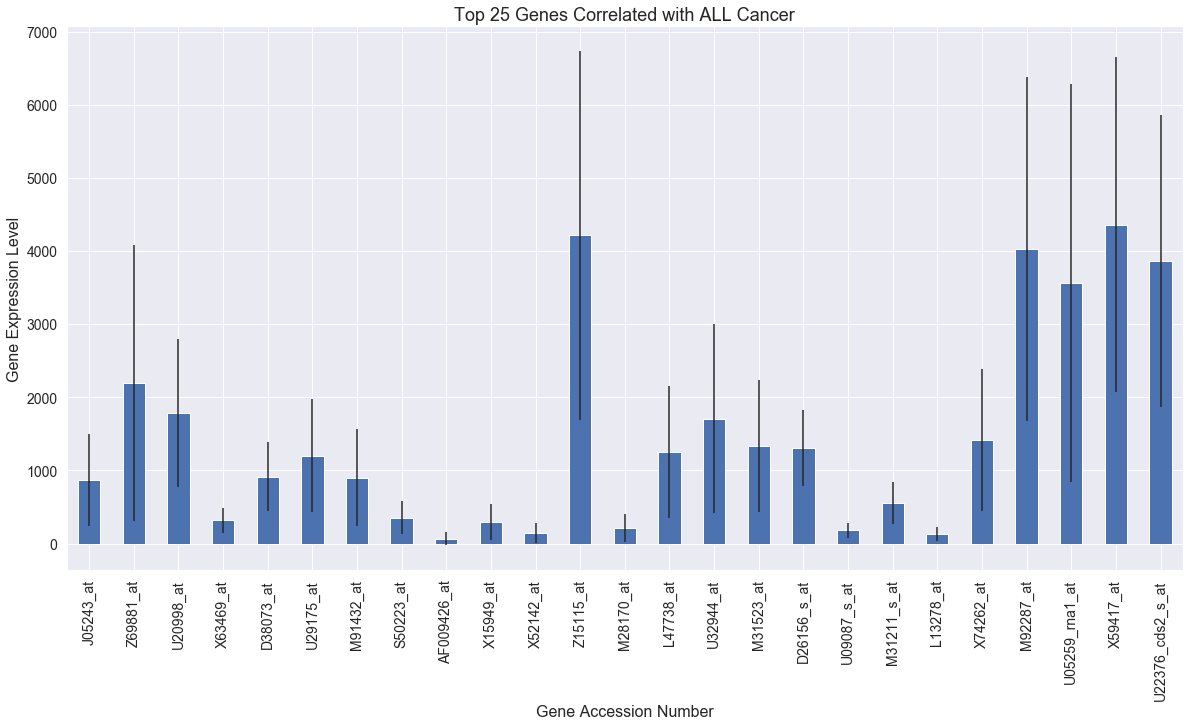

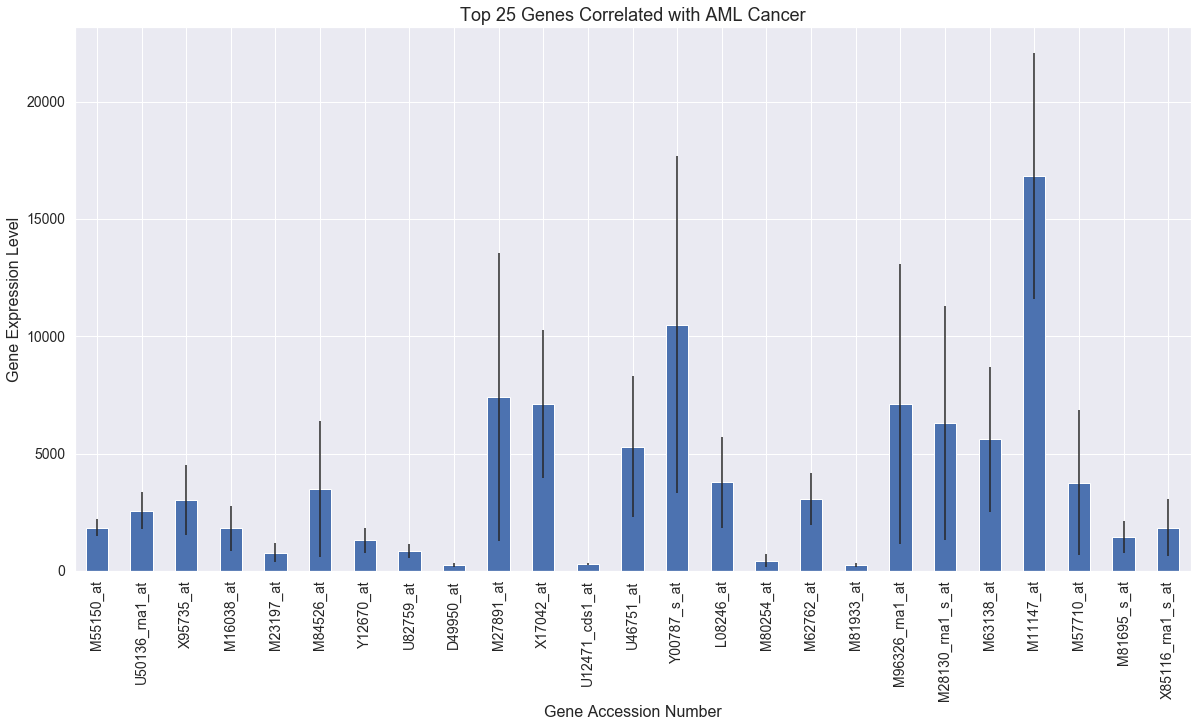

In [7]:
#Plot bar graphs of the mean gene expression for the top 25 ALL genes with standard deviations
top_genes_ALL['ALL_mean'].plot(kind='bar', yerr=top_genes_ALL['ALL_stdev'], figsize=(20,10))
plt.xlabel('Gene Accession Number')
plt.ylabel('Gene Expression Level')
plt.title('Top 25 Genes Correlated with ALL Cancer')
plt.show()

#Plot bar graphs of the mean gene expression for the top 25 AML genes with standard deviations
top_genes_AML['AML_mean'].plot(kind='bar', yerr=top_genes_AML['AML_stdev'], figsize=(20,10))
plt.xlabel('Gene Accession Number')
plt.ylabel('Gene Expression Level')
plt.title('Top 25 Genes Correlated with AML Cancer')
plt.show()

I also wanted to go back to the original dataset with the gene expression data for each sample (rather than just the mean) and look at boxplots for each of the top 50 genes I identified.

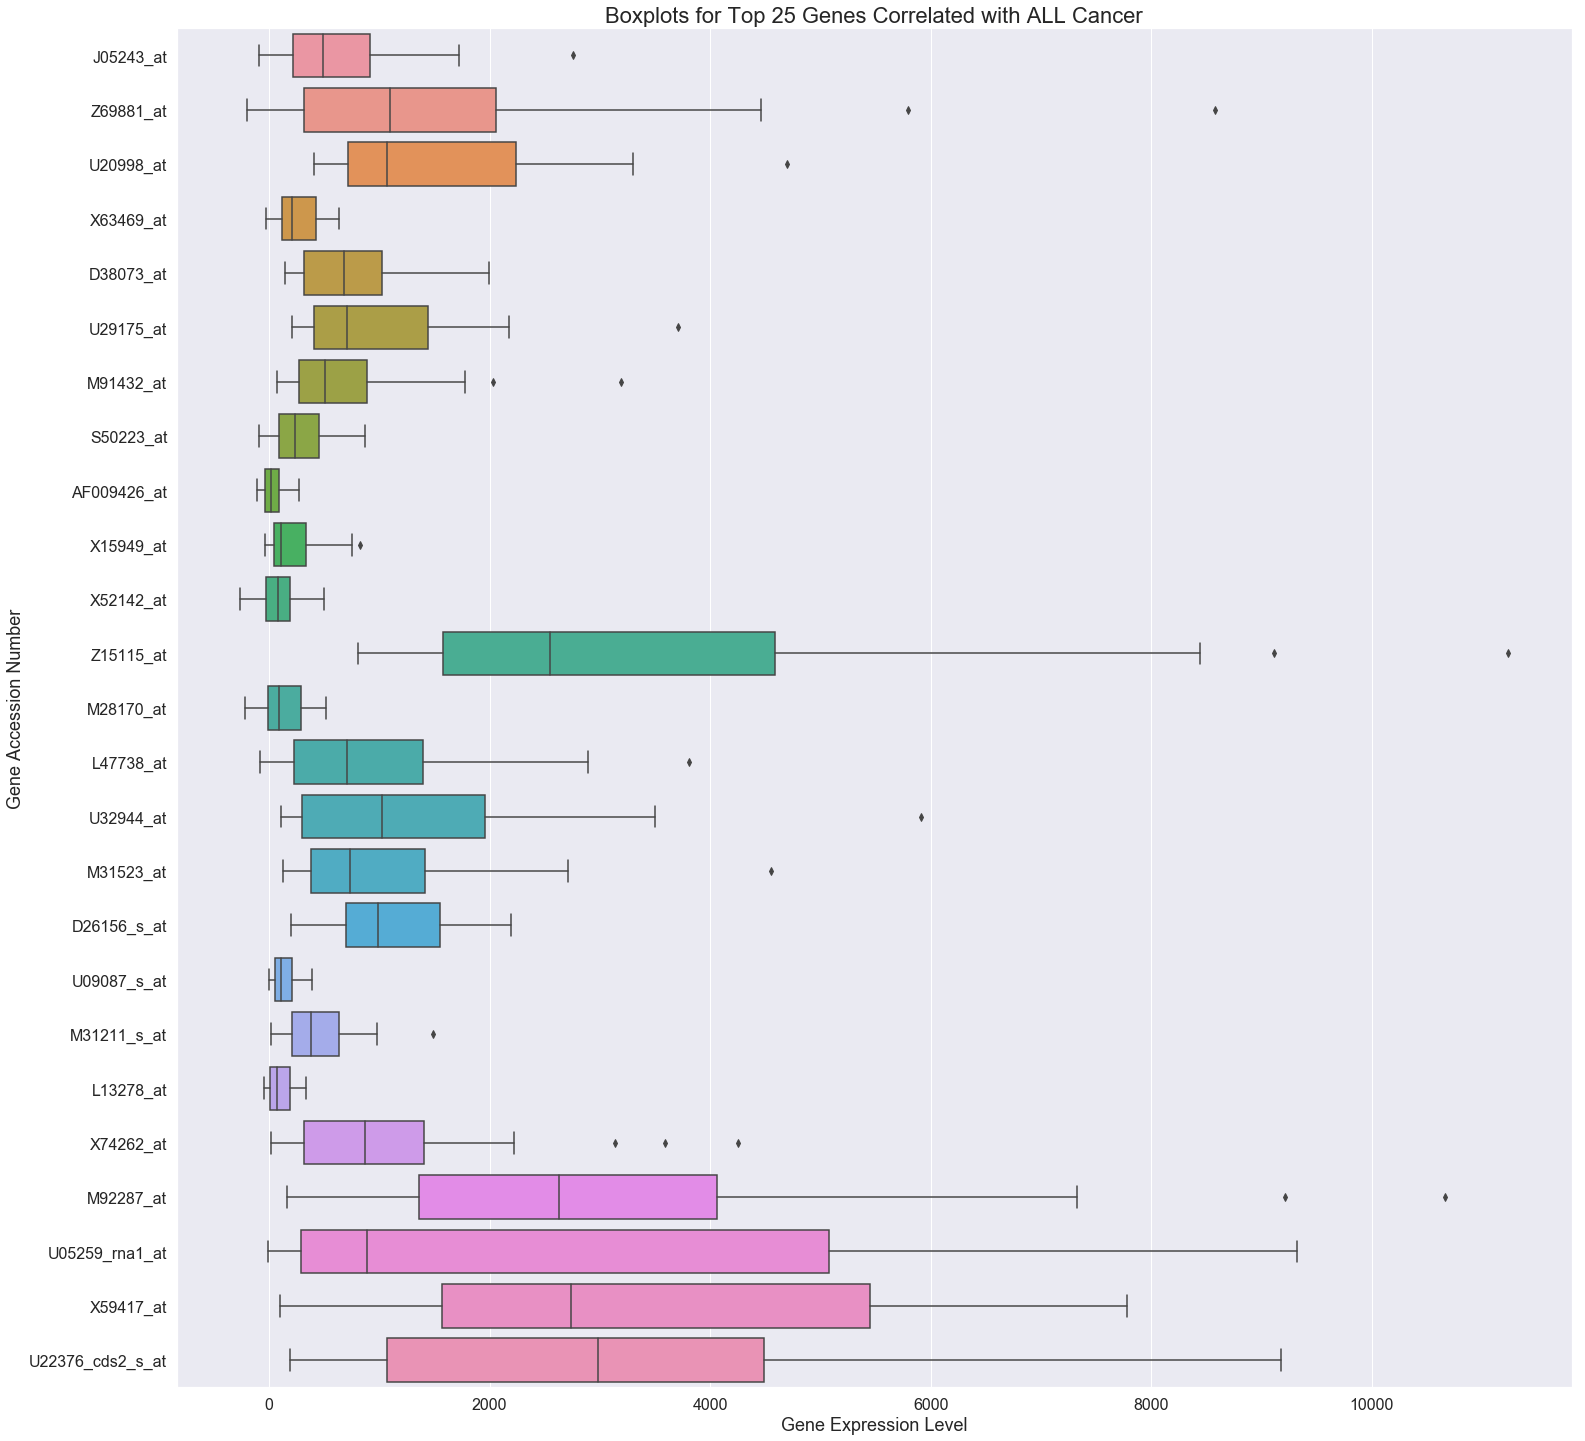

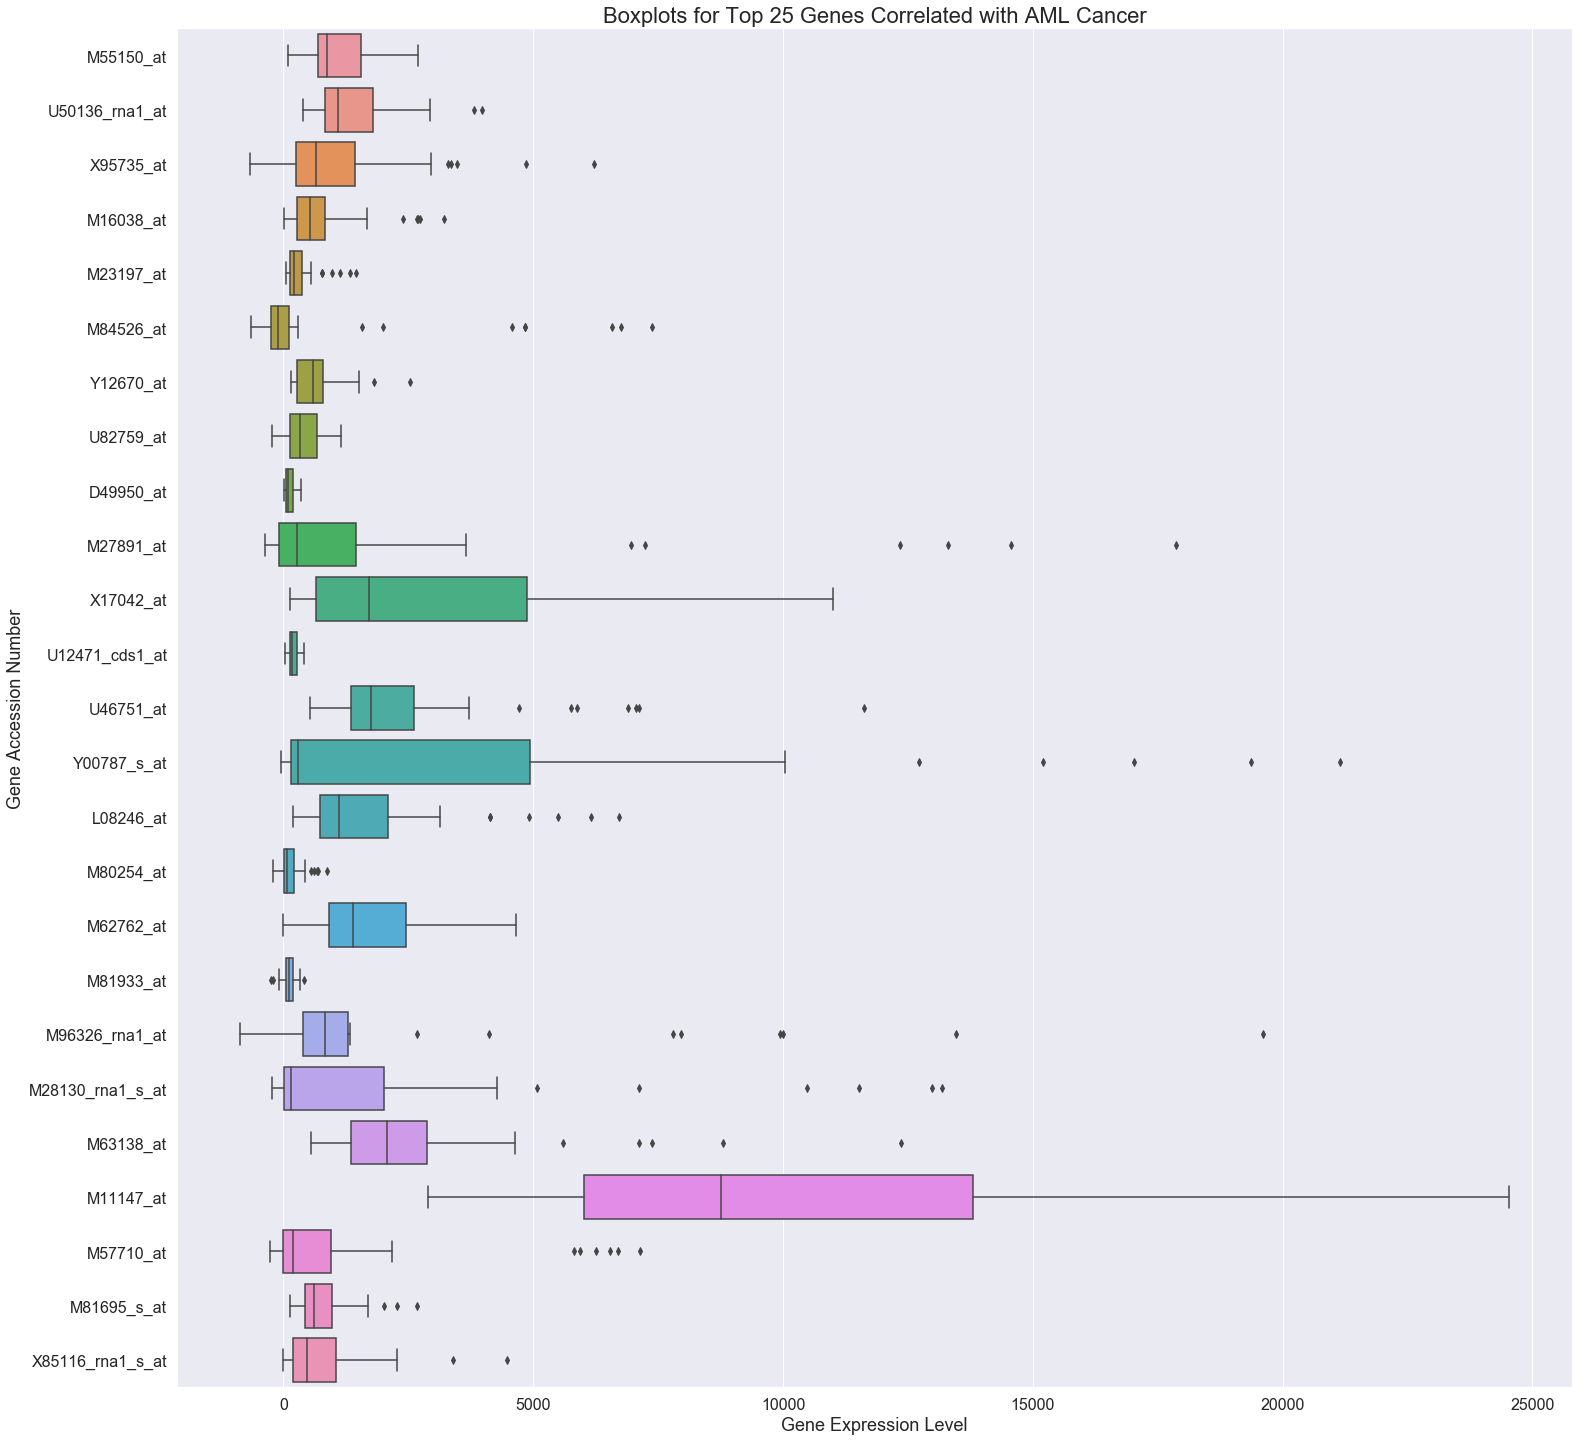

In [8]:
#Creat lists for the top ALL and top AML genes
top_ALL_list = list(top_genes_ALL.index)
top_AML_list = list(top_genes_AML.index)

#Plot boxplots of the gene expression data across all samples for top 25 ALL genes
top_ALL_data = cleaned_data.loc[top_ALL_list].transpose()
plt.figure(figsize=(25, 25))
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Gene Expression Level', fontsize=18)
plt.ylabel('Gene Accession Number', fontsize=18)
plt.title('Boxplots for Top 25 Genes Correlated with ALL Cancer', fontsize=22)
sns.boxplot(data=top_ALL_data, orient='h')
plt.show()

#Plot boxplots of the gene expression data across all samples for top 25 ALL genes
top_AML_data = cleaned_data.loc[top_AML_list].transpose()
plt.figure(figsize=(25, 25))
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Gene Expression Level', fontsize=18)
plt.ylabel('Gene Accession Number', fontsize=18)
plt.title('Boxplots for Top 25 Genes Correlated with AML Cancer', fontsize=22)
sns.boxplot(data=top_AML_data, orient='h')
plt.show()

One of the best ways to visualize gene expression data is by using a heatmap, which makes it very easy to see patterns in the gene expression levels across many samples. As there is a wide range of expression levels in the top 50 genes, each gene was first normalized using the maximum and minimum expression levels so that patterns across the individual samples could be detected. As you can see in the heatmap below, there is a clear difference in the gene expression patterns of the ALL samples (samples 1-27) and the AML samples (samples 28-38). As expected, the top 25 genes are more highly expressed in the ALL samples compared to the AML samples, while the bottom 25 genes are more highly expressed in the AML samples.

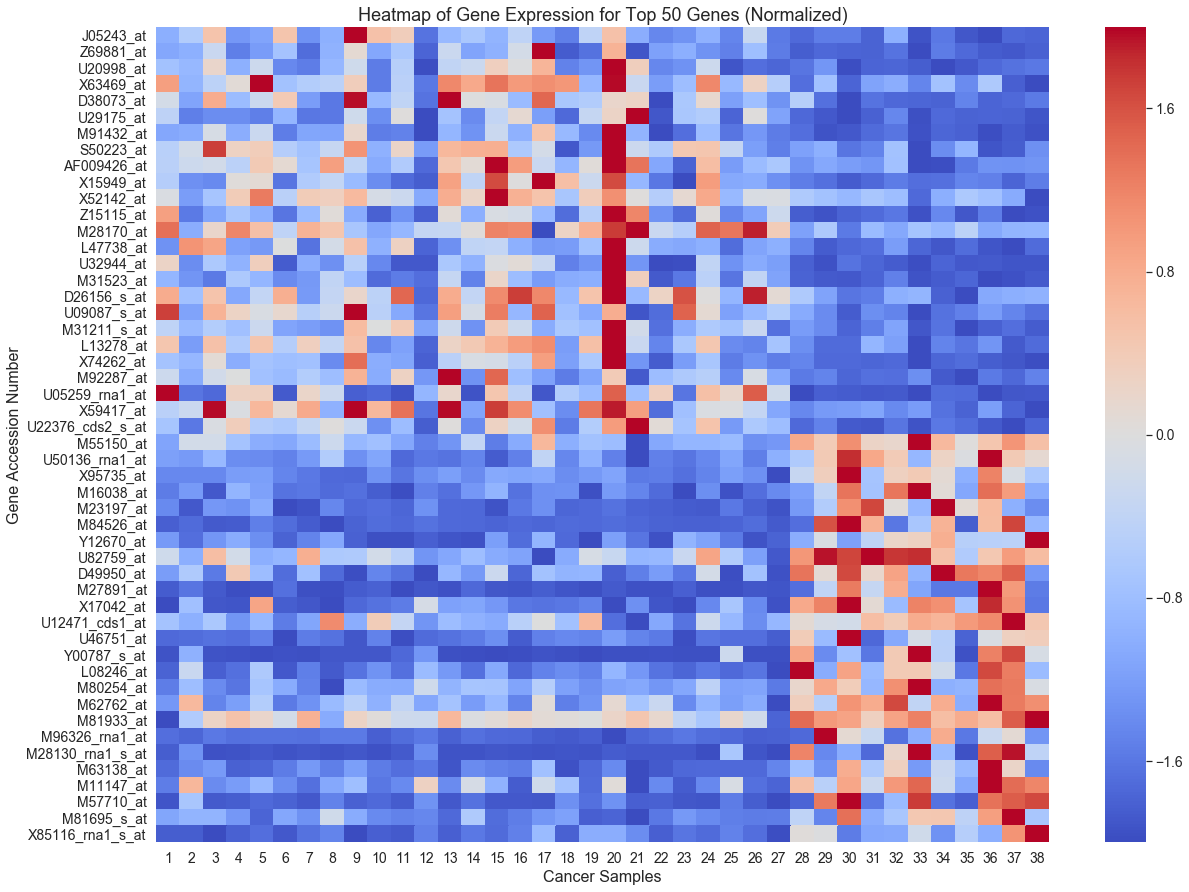

In [9]:
#Create a list with all of the top gene names
top_genes_list = top_ALL_list + top_AML_list

#Select only the top genes from the original complete data set
data_top_genes = cleaned_data.loc[top_genes_list]

#Merge with the top_genes dataframe to combine with ALL & AML means, standard deviations, and correlation calculations
gene_data = pd.concat([data_top_genes, top_genes], axis=1, sort=True)

def normalize(df):
    #Normalize scales each gene to have values ranging from -2 to 2 across the ALL and AML samples
    norm_df = df
    for index, row in df.iterrows():
        norm_row = []
        for x in row:
            norm_value = -2 + ((x - row.min())*(4) / (row.max() - row.min()))
            norm_row.append(norm_value)
        norm_df.loc[index] = norm_row
    return norm_df

#Normalize the gene expression data
df_top_norm = normalize(data_top_genes)

#Plot the gene expression heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(df_top_norm, center=0, cmap='coolwarm')
plt.xlabel('Cancer Samples')
plt.ylabel('Gene Accession Number')
plt.title('Heatmap of Gene Expression for Top 50 Genes (Normalized)')
plt.show()

I also tried a different method to standardize the individual expression level measurments across each gene. In the heatmap below, I standardized each measurement using the following formula:

$$ (x - \mu_{row}) / (\sigma_{row}) $$

where x is an indivudual measurement, $ \mu_{row} $ is the mean of all 38 measurements for that gene, and $\sigma_{row}$ is the standard deviation of all 38 measurements. As you can see below, the color range of this heatmap is more narrow than the previous heatmap.

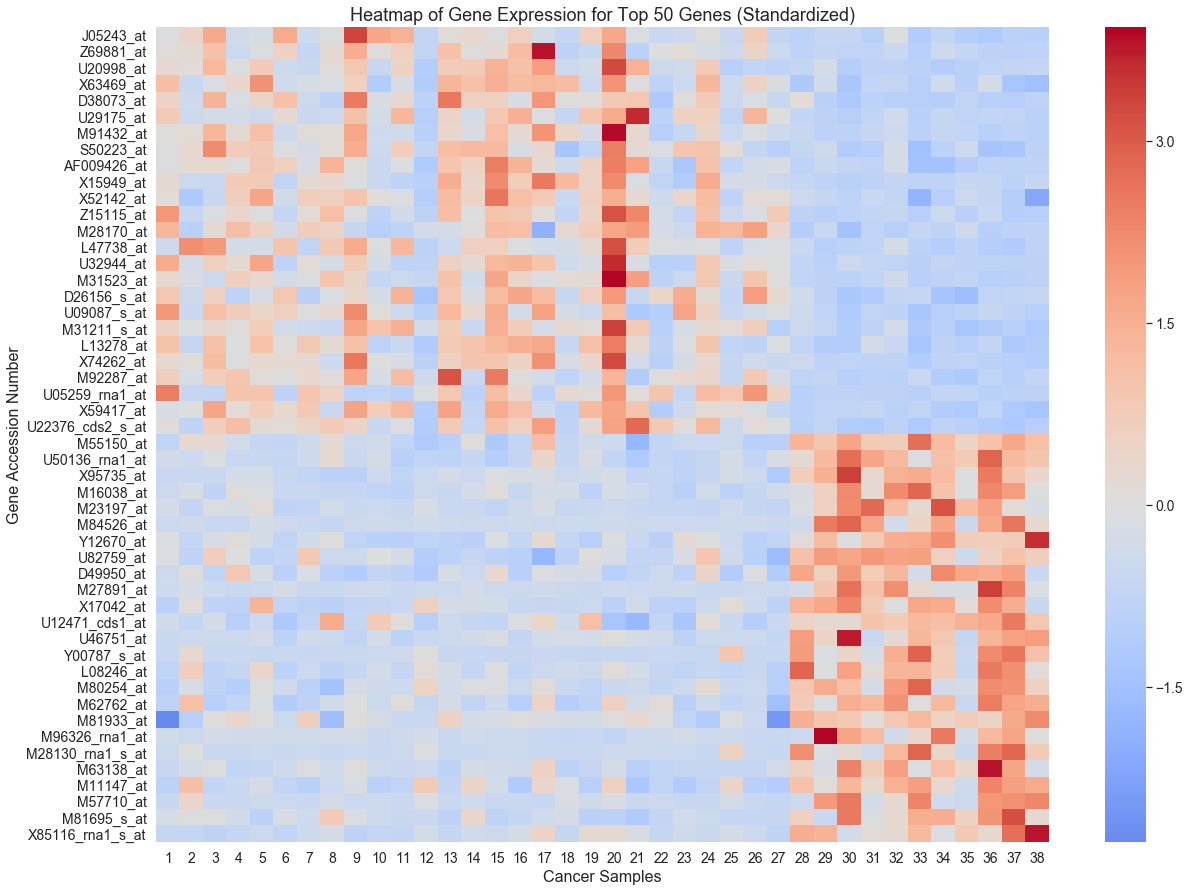

In [10]:
#Here I am testing a different way to standardize the gene expression data
def standardize(df):
    #Standardizes expression level for each gene based on the mean and standard deviation across all samples
    stand_df = df
    for index, row in df.iterrows():
        stand_row = []
        for x in row:
            stand_value = (x - row.mean())/(row.std())
            stand_row.append(stand_value)
        stand_df.loc[index] = stand_row
    return stand_df

#Standardize the gene expression data
df_top_stand = standardize(data_top_genes)

#Plot the gene expression heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(df_top_stand, center=0, cmap='coolwarm')
plt.xlabel('Cancer Samples')
plt.ylabel('Gene Accession Number')
plt.title('Heatmap of Gene Expression for Top 50 Genes (Standardized)')
plt.show()

Finally, I wanted to revist the scatter plot from the beginning, but this time I highlighted the 50 genes with the highest correlation values.

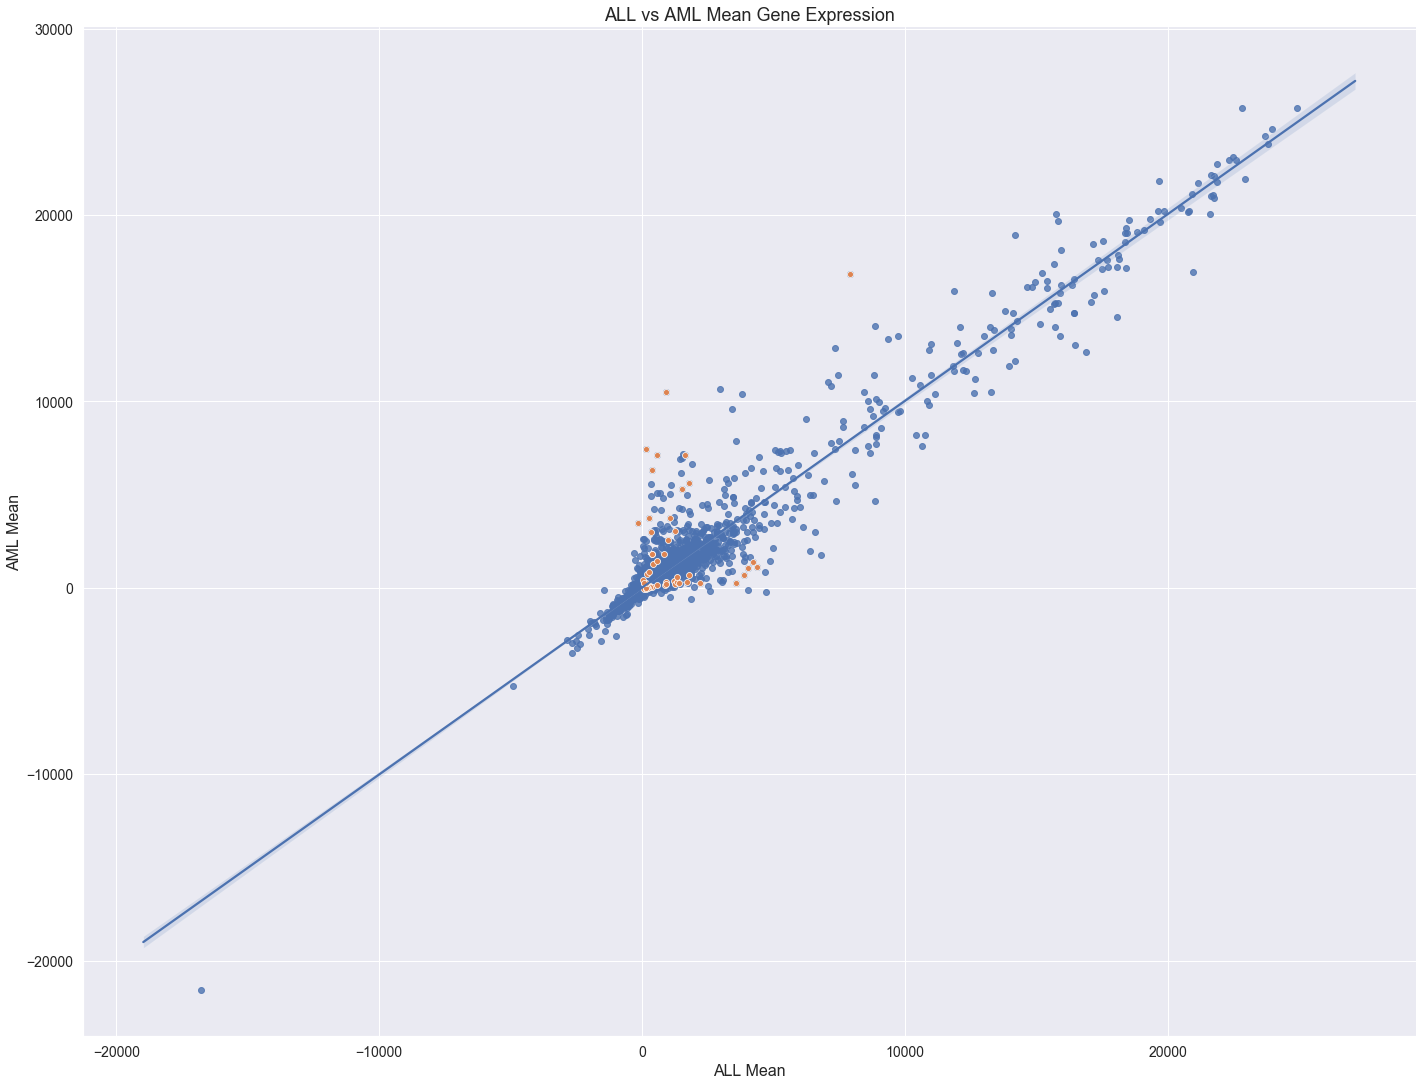

In [11]:
#Finally, I want to highlight the positions of the 50 most highly correlated genes in the ALL vs AML original scatterplot
top_means = means.loc[top_genes_list]
sns.lmplot(x='ALL_mean', y='AML_mean', data=means, height= 15, aspect=1.33)
sns.scatterplot(x='ALL_mean', y='AML_mean', data=top_means)
plt.xlabel('ALL Mean')
plt.ylabel('AML Mean')
plt.title('ALL vs AML Mean Gene Expression')
plt.show()